In [28]:
import lightgbm
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import random
import os

# 시드 고정 함수
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
    lightgbm.seed = seed

set_seed(42)

In [29]:
import warnings

warnings.filterwarnings('ignore')

import pandas as pd

data = pd.read_csv('/Users/baby_cow/Desktop/AI/ML_competition/data/geocoded_addresses_12.csv')
data.columns

Index(['Unnamed: 0', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '거래유형', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
       'k-135㎡초과', '건축면적', '주차대수', 'target', 'is_test', 'latitude',
       'longitude', 'address', 'address_apt', 'address_apt_sqm', '구', '동',
       '강남여부', 'mean_target', 'apt_mean_target', 'address_mean_target',
       'mean_target_gu_dong', 'closest_bus_stop_distance',
       'closest_subway_station_distance', 'bus_stop_count_500m',
       'subway_station_count_500m', 'bus_stop_count_750m',
       'subway_station_count_750m', 'bus_stop_count_1000m',
       'subway_station_count_1000m', 'square_meter',
       'monthly_mean_target_rate', 'adjusted_square_meter', 'is_outlier',
       'year', 'month', 'distance_to_lead_house'],
      dtype='object')

In [30]:
temp_index = list(range(len(data)))
data['id'] = temp_index
selected_columns = ['id', '본번', '부번', '아파트명', '계약년월', '계약일', '층', '건축년도', '도로명',
        '거래유형', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',
        'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
        'k-135㎡초과', '건축면적', '주차대수', 'target', 'is_test', 'latitude',
        'longitude', '구', '동', 'closest_bus_stop_distance',
        'closest_subway_station_distance', 'bus_stop_count_500m',
        'subway_station_count_500m', 'bus_stop_count_750m',
        'subway_station_count_750m', 'bus_stop_count_1000m',
        'subway_station_count_1000m', 'is_outlier',
        'distance_to_lead_house', '전용면적(㎡)']

df = data[selected_columns]

df['전용면적'] = df['전용면적(㎡)']
df.drop(columns=['전용면적(㎡)'], axis=1, inplace=True)

df['계약년'] = df['계약년월'].map(lambda x : int(str(x)[:4]))

# 지역별 chunk 나누기

In [31]:
chunks = {}

regions = df['구'].unique()

for region in regions:
    chunk = df[df['구'] == region]
    chunk.sort_values(by='계약년월')
    chunks[region] = chunk

# log_mean_target 만들기

In [32]:
import numpy as np

for region in regions:
    chunk = chunks[region]

    for dong in chunk['동'].unique():
        dong_temp_df = chunk.loc[(chunk['is_test'] == 0) & (chunk['동'] == dong), :]
        chunk.loc[(chunk['동'] == dong), '동 로그 평균'] = np.log(np.log(dong_temp_df['target'].mean()))

        for apart in dong_temp_df['아파트명'].unique():
            apart_temp_df = dong_temp_df.loc[(dong_temp_df['아파트명'] == apart), :]        
            chunk.loc[(chunk['동'] == dong) & (chunk['아파트명'] == apart), '아파트 로그 평균'] = np.log(np.log(apart_temp_df['target'].mean()))

            for house in apart_temp_df['전용면적'].unique():
                house_temp_df = apart_temp_df.loc[(apart_temp_df['전용면적'] == house), :]
                chunk.loc[(chunk['동'] == dong) & (chunk['아파트명'] == apart) & (chunk['전용면적'] == house), '집 로그 평균'] = np.log(np.log(house_temp_df['target'].mean()))

    

# 모델 학습

In [34]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

result_board = []
result = pd.DataFrame()

params = {
    'objective': 'regression', 
    'metric': 'rmse',           
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'lambda_l2' : 0.1,
    'drop_rate' : 0.2,
    'verbose' : -1
}

for region in tqdm(regions):
    chunk = chunks[region]

    select_cols = ['id', '본번', '부번', '계약일', '층', '건축년도',
        'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',
        'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
        'k-135㎡초과', '건축면적', '주차대수', 'target', 'is_test', 'latitude',
        'longitude', 'closest_bus_stop_distance',
        'closest_subway_station_distance', 'bus_stop_count_500m',
        'subway_station_count_500m', 'bus_stop_count_750m',
        'subway_station_count_750m', 'bus_stop_count_1000m',
        'subway_station_count_1000m',
        'distance_to_lead_house', '전용면적', '동 로그 평균', '아파트 로그 평균', '집 로그 평균',]
    
    chunk = chunk[select_cols]

    train_chunk = chunk.query('is_test == 0')
    test_chunk = chunk.query('is_test == 1')

    train_chunk.drop(columns=['is_test', 'id'], axis=1, inplace = True)
    test_chunk.drop(columns = ['is_test'], axis = 1, inplace = True)

    X = train_chunk.drop(columns=['target'], axis=1)
    y = train_chunk['target']

    tscv = TimeSeriesSplit(n_splits = 17)
    
    min_rmse = int(1e9)

    model = None
    for fold, (train_index, val_index) in enumerate(tscv.split(X), 1):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        train_data = lgb.Dataset(X_train, label = y_train)
        val_data = lgb.Dataset(X_val, label = y_val, reference = train_data)

        if model :
            model = lgb.train(
                params,
                train_data,
                num_boost_round=5000,
                init_model = model,
                valid_sets = [train_data, val_data],
                callbacks = [lgb.early_stopping(stopping_rounds=5), lgb.log_evaluation(period=-1)],
            )
        else:
            model = lgb.train(
                params,
                train_data,
                num_boost_round=5000,
                valid_sets = [train_data, val_data],
                callbacks = [lgb.early_stopping(stopping_rounds=5), lgb.log_evaluation(period=-1)],
            )
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        min_rmse = min(min_rmse, rmse)

    result_board.append({"지역" : region, "validation RMSE" : min_rmse})

    final_train_data = lgb.Dataset(X, label=y)
    final_model = lgb.train(params,
                            final_train_data,
                            init_model = model,
                            num_boost_round=model.best_iteration,
                            callbacks = [lgb.log_evaluation(period=-1)],
                            )

    test_X = test_chunk.drop(columns=['id', 'target'], axis=1)
    pred = final_model.predict(test_X)

    test_chunk['target'] = pred

    result = pd.concat([result, test_chunk[['id', 'target']]]) 


  0%|          | 0/25 [00:00<?, ?it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[33]	training's rmse: 15476.6	valid_1's rmse: 49425.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[60]	training's rmse: 13957.9	valid_1's rmse: 16358.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[71]	training's rmse: 13478.2	valid_1's rmse: 80063.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[161]	training's rmse: 21424.1	valid_1's rmse: 88880.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[210]	training's rmse: 28711.9	valid_1's rmse: 55377.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[227]	training's rmse: 29096.1	valid_1's rmse: 44917.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[228]	tr

  4%|▍         | 1/25 [00:09<03:42,  9.26s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[13]	training's rmse: 8638.35	valid_1's rmse: 19250.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[46]	training's rmse: 4710.74	valid_1's rmse: 7286.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[47]	training's rmse: 5499.25	valid_1's rmse: 24936.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[111]	training's rmse: 5925.49	valid_1's rmse: 42988.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[123]	training's rmse: 11768.1	valid_1's rmse: 18641.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[147]	training's rmse: 10751.4	valid_1's rmse: 15737.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[148]	tra

  8%|▊         | 2/25 [00:16<03:03,  8.00s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[79]	training's rmse: 2286.05	valid_1's rmse: 6683.13
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[121]	training's rmse: 2351.6	valid_1's rmse: 3311.56
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[122]	training's rmse: 2672.47	valid_1's rmse: 31556.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[175]	training's rmse: 5450.19	valid_1's rmse: 17864.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[176]	training's rmse: 8835.75	valid_1's rmse: 10210.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[190]	training's rmse: 6244.95	valid_1's rmse: 10290.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[194]	t

 12%|█▏        | 3/25 [00:21<02:24,  6.58s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[26]	training's rmse: 4758.3	valid_1's rmse: 12432.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[45]	training's rmse: 4377.36	valid_1's rmse: 5856.17
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[46]	training's rmse: 4802.81	valid_1's rmse: 38739
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[76]	training's rmse: 10489.2	valid_1's rmse: 24211.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[124]	training's rmse: 10610.1	valid_1's rmse: 10335.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[158]	training's rmse: 9908.46	valid_1's rmse: 15885.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[197]	traini

 16%|█▌        | 4/25 [00:28<02:24,  6.90s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[21]	training's rmse: 3862.95	valid_1's rmse: 9522.38
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[52]	training's rmse: 3074.08	valid_1's rmse: 3884.54
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[53]	training's rmse: 3322.28	valid_1's rmse: 37074.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[91]	training's rmse: 8313.51	valid_1's rmse: 11263.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[102]	training's rmse: 8472.03	valid_1's rmse: 14272.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[127]	training's rmse: 8039.78	valid_1's rmse: 13945.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[128]	tra

 20%|██        | 5/25 [00:34<02:07,  6.36s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[26]	training's rmse: 7104.99	valid_1's rmse: 22913.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[56]	training's rmse: 6013.32	valid_1's rmse: 8082.16
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[64]	training's rmse: 6084.38	valid_1's rmse: 51067
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[146]	training's rmse: 10307.3	valid_1's rmse: 59531.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[193]	training's rmse: 12765.9	valid_1's rmse: 38049.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[206]	training's rmse: 12788.6	valid_1's rmse: 21706.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[219]	trai

 24%|██▍       | 6/25 [00:39<01:57,  6.16s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[41]	training's rmse: 2662.11	valid_1's rmse: 9666.46
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[61]	training's rmse: 3180.12	valid_1's rmse: 5941.25
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[67]	training's rmse: 3720.12	valid_1's rmse: 34676.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[94]	training's rmse: 7110.45	valid_1's rmse: 15155.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[100]	training's rmse: 7901.38	valid_1's rmse: 19372.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[142]	training's rmse: 6970.71	valid_1's rmse: 12559.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[169]	tra

 28%|██▊       | 7/25 [00:46<01:54,  6.37s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[35]	training's rmse: 2203.81	valid_1's rmse: 7355.12
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[36]	training's rmse: 4979.02	valid_1's rmse: 11623.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[45]	training's rmse: 4311.58	valid_1's rmse: 26312.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[55]	training's rmse: 8182.98	valid_1's rmse: 19031.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[56]	training's rmse: 10596	valid_1's rmse: 8027.48
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[57]	training's rmse: 9715.75	valid_1's rmse: 8288.58
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[62]	training

 32%|███▏      | 8/25 [00:49<01:29,  5.28s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[30]	training's rmse: 2653.48	valid_1's rmse: 8618.39
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[44]	training's rmse: 2980.26	valid_1's rmse: 3821.31
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[45]	training's rmse: 3207.59	valid_1's rmse: 34732.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[79]	training's rmse: 6326.2	valid_1's rmse: 24549.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[103]	training's rmse: 7146.23	valid_1's rmse: 17585.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[110]	training's rmse: 7776.85	valid_1's rmse: 14765.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[111]	trai

 36%|███▌      | 9/25 [00:56<01:33,  5.86s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[22]	training's rmse: 2617.04	valid_1's rmse: 6957.71
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[39]	training's rmse: 2533.17	valid_1's rmse: 6319.73
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[42]	training's rmse: 3761.62	valid_1's rmse: 28912.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[72]	training's rmse: 7054.8	valid_1's rmse: 16026.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[126]	training's rmse: 6311.15	valid_1's rmse: 13828.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[141]	training's rmse: 6275.31	valid_1's rmse: 9437.32
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[142]	trai

 40%|████      | 10/25 [01:02<01:27,  5.83s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[41]	training's rmse: 4826.3	valid_1's rmse: 9652.61
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[56]	training's rmse: 4400.6	valid_1's rmse: 7421.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[84]	training's rmse: 4079.53	valid_1's rmse: 37292.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[130]	training's rmse: 9981.66	valid_1's rmse: 20039.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[169]	training's rmse: 10722.6	valid_1's rmse: 13606.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[205]	training's rmse: 10291.5	valid_1's rmse: 22170.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[255]	train

 44%|████▍     | 11/25 [01:09<01:27,  6.26s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[29]	training's rmse: 6351.53	valid_1's rmse: 16027.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[85]	training's rmse: 5296.46	valid_1's rmse: 6372.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[93]	training's rmse: 5321.03	valid_1's rmse: 59231
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[146]	training's rmse: 12913.4	valid_1's rmse: 30791.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[150]	training's rmse: 15372.4	valid_1's rmse: 21071.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[164]	training's rmse: 12717	valid_1's rmse: 21431
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[167]	training'

 48%|████▊     | 12/25 [01:15<01:18,  6.02s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[29]	training's rmse: 7208.26	valid_1's rmse: 16555.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[54]	training's rmse: 6963.44	valid_1's rmse: 7242.21
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[55]	training's rmse: 6959.68	valid_1's rmse: 52990.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[153]	training's rmse: 11211.1	valid_1's rmse: 35505
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[203]	training's rmse: 13483.3	valid_1's rmse: 18688
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[224]	training's rmse: 13191.8	valid_1's rmse: 20293.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[258]	traini

 52%|█████▏    | 13/25 [01:21<01:14,  6.21s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[48]	training's rmse: 5415.23	valid_1's rmse: 10331.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[67]	training's rmse: 4680.07	valid_1's rmse: 8228.69
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[68]	training's rmse: 5980.13	valid_1's rmse: 48870.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[97]	training's rmse: 10990.7	valid_1's rmse: 23531.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[108]	training's rmse: 11425.7	valid_1's rmse: 17387.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[152]	training's rmse: 10162.6	valid_1's rmse: 21389.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[188]	tra

 56%|█████▌    | 14/25 [01:27<01:08,  6.19s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[16]	training's rmse: 20878.8	valid_1's rmse: 47242.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[73]	training's rmse: 11669.1	valid_1's rmse: 14736.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[89]	training's rmse: 11149.3	valid_1's rmse: 104248
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[151]	training's rmse: 26965.2	valid_1's rmse: 59336.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[192]	training's rmse: 30040.9	valid_1's rmse: 63992.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[254]	training's rmse: 29112.9	valid_1's rmse: 52466.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[318]	tra

 60%|██████    | 15/25 [01:36<01:09,  6.96s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[42]	training's rmse: 8268.59	valid_1's rmse: 18575.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[72]	training's rmse: 6795.13	valid_1's rmse: 6006.57
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[73]	training's rmse: 6485.94	valid_1's rmse: 80147.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[129]	training's rmse: 15466.8	valid_1's rmse: 32192.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[153]	training's rmse: 15186.3	valid_1's rmse: 29097.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[184]	training's rmse: 14315.1	valid_1's rmse: 21543.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[240]	tr

 64%|██████▍   | 16/25 [01:43<01:01,  6.87s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[47]	training's rmse: 3882.62	valid_1's rmse: 8059.82
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[73]	training's rmse: 3569.13	valid_1's rmse: 4713.17
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[94]	training's rmse: 3428.25	valid_1's rmse: 38639.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[149]	training's rmse: 7331.7	valid_1's rmse: 30395.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[156]	training's rmse: 10618.9	valid_1's rmse: 16665.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[159]	training's rmse: 10651.4	valid_1's rmse: 16397
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[161]	train

 68%|██████▊   | 17/25 [01:49<00:53,  6.70s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[30]	training's rmse: 8825.71	valid_1's rmse: 29672.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[57]	training's rmse: 8119.86	valid_1's rmse: 9883.35
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[78]	training's rmse: 7409.77	valid_1's rmse: 40809.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[163]	training's rmse: 12398.3	valid_1's rmse: 79962.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[197]	training's rmse: 18823.2	valid_1's rmse: 32411.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[230]	training's rmse: 19238.2	valid_1's rmse: 38974.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[263]	tr

 72%|███████▏  | 18/25 [01:59<00:53,  7.63s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[22]	training's rmse: 7094.36	valid_1's rmse: 15399.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[47]	training's rmse: 5310.07	valid_1's rmse: 8694.93
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[48]	training's rmse: 6450.89	valid_1's rmse: 28192.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[87]	training's rmse: 5688.33	valid_1's rmse: 58186.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[173]	training's rmse: 7114.57	valid_1's rmse: 27642.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[187]	training's rmse: 8118.43	valid_1's rmse: 30949.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[188]	tra

 76%|███████▌  | 19/25 [02:05<00:42,  7.14s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[56]	training's rmse: 4697.79	valid_1's rmse: 15389.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[76]	training's rmse: 5672.27	valid_1's rmse: 7533.05
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[77]	training's rmse: 6222.56	valid_1's rmse: 50188.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[122]	training's rmse: 12068.7	valid_1's rmse: 46584.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[183]	training's rmse: 13874.6	valid_1's rmse: 17069.1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[235]	training's rmse: 12973	valid_1's rmse: 19205.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[242]	trai

 80%|████████  | 20/25 [02:13<00:36,  7.35s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[92]	training's rmse: 7317.84	valid_1's rmse: 72047.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[140]	training's rmse: 9206.28	valid_1's rmse: 18660.9
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[141]	training's rmse: 12553.9	valid_1's rmse: 99320.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[191]	training's rmse: 21524.2	valid_1's rmse: 74042.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[215]	training's rmse: 23123	valid_1's rmse: 54887.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[279]	training's rmse: 21653.9	valid_1's rmse: 35287.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[298]	tr

 84%|████████▍ | 21/25 [02:19<00:28,  7.13s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[31]	training's rmse: 3257.59	valid_1's rmse: 8940.43
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[59]	training's rmse: 3328.65	valid_1's rmse: 5926.92
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[83]	training's rmse: 3149.33	valid_1's rmse: 26683
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[170]	training's rmse: 5165.39	valid_1's rmse: 27325.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[228]	training's rmse: 6081	valid_1's rmse: 9480.58
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[258]	training's rmse: 5977.21	valid_1's rmse: 12073.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[309]	trainin

 88%|████████▊ | 22/25 [02:27<00:21,  7.26s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[50]	training's rmse: 4613.62	valid_1's rmse: 12481.3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[87]	training's rmse: 5081.76	valid_1's rmse: 11881.8
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[111]	training's rmse: 5279.73	valid_1's rmse: 37784.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[155]	training's rmse: 8991.95	valid_1's rmse: 35147.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[173]	training's rmse: 10327.1	valid_1's rmse: 17457
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[190]	training's rmse: 9561.98	valid_1's rmse: 15842.7
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[202]	tra

 92%|█████████▏| 23/25 [02:30<00:12,  6.07s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[35]	training's rmse: 4614.52	valid_1's rmse: 14864.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[87]	training's rmse: 5260.54	valid_1's rmse: 16414.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[88]	training's rmse: 9778.24	valid_1's rmse: 37824
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[134]	training's rmse: 8713.39	valid_1's rmse: 23117.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[153]	training's rmse: 9033.45	valid_1's rmse: 17739.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[181]	training's rmse: 8626.55	valid_1's rmse: 14874.2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[225]	trai

 96%|█████████▌| 24/25 [02:34<00:05,  5.51s/it]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[26]	training's rmse: 3179.34	valid_1's rmse: 6582.72
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[60]	training's rmse: 2598.48	valid_1's rmse: 8745.96
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[108]	training's rmse: 3108.33	valid_1's rmse: 24478.4
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[150]	training's rmse: 5258.57	valid_1's rmse: 15315.5
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[175]	training's rmse: 5203.84	valid_1's rmse: 11973
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[195]	training's rmse: 5112.91	valid_1's rmse: 11017.6
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[216]	tra

100%|██████████| 25/25 [02:42<00:00,  6.49s/it]


# 결과 확인

In [35]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'  # MacOS의 기본 한글 폰트
plt.rcParams['axes.unicode_minus'] = False   # 마이너스 기호 깨짐 방지

7881.223842367518


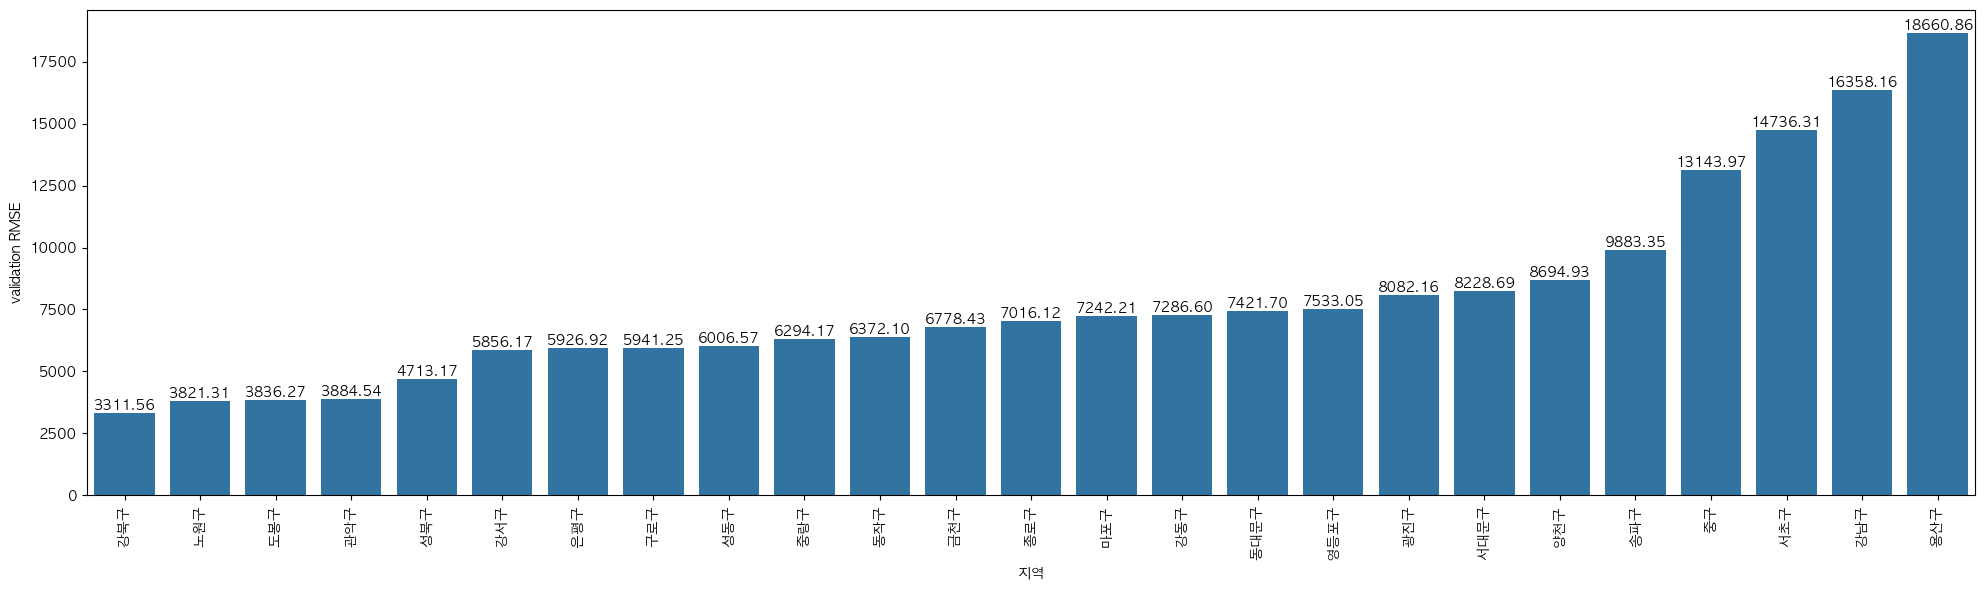

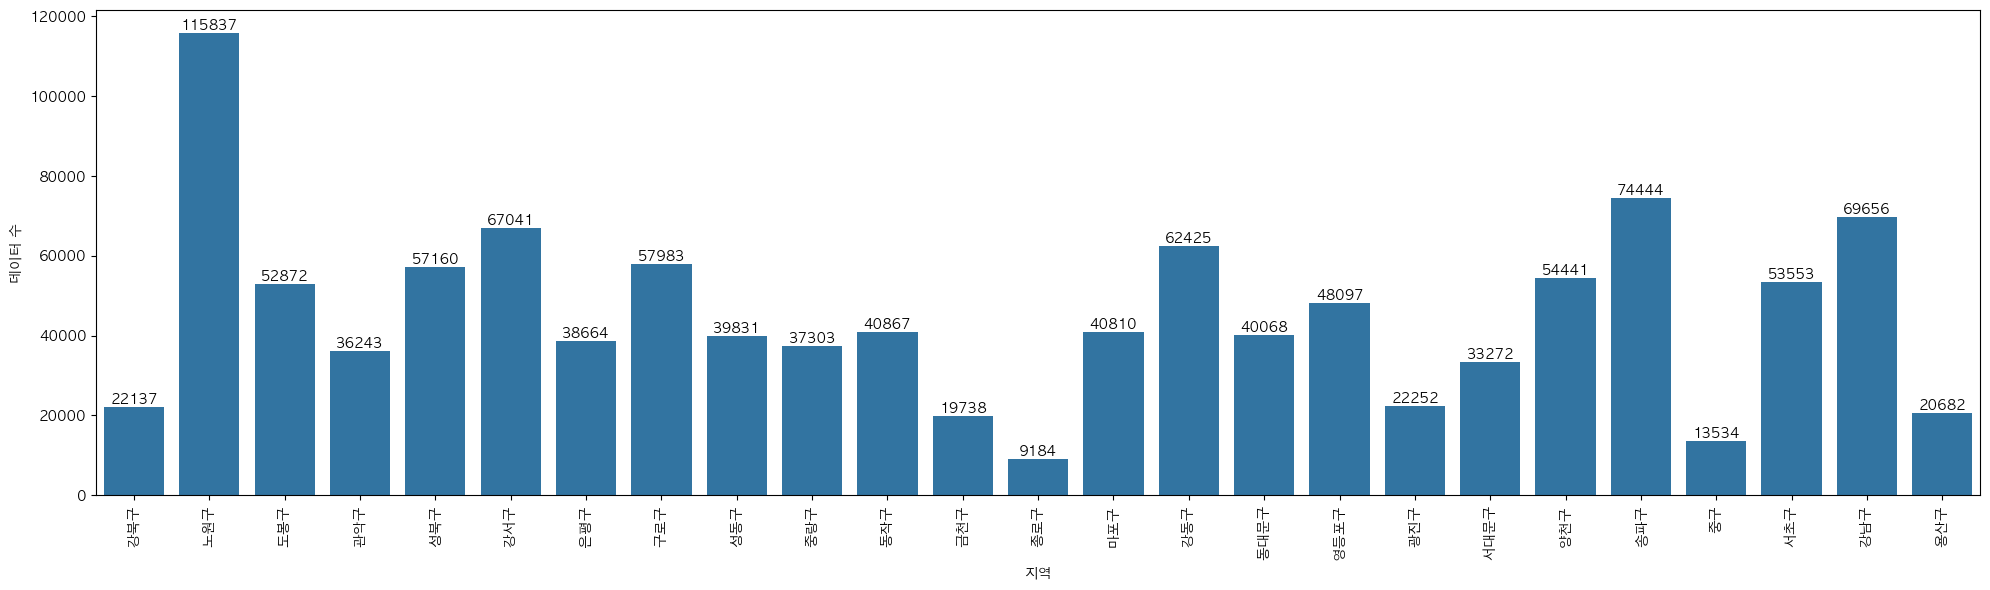

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

result_df = pd.DataFrame(result_board)
result_df = result_df.sort_values(by='validation RMSE')
result_df = result_df[-30:]

print(result_df['validation RMSE'].mean())

# 그래프 생성
plt.figure(figsize=(20, 6))
ax = sns.barplot(data=result_df, x='지역', y='validation RMSE')

# 바 위에 값 표시
for i, v in enumerate(result_df['validation RMSE']):
    ax.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

temp_list = [{"지역" : region, "데이터 수" : len(chunks[region])} for region in result_df['지역']]
temp_df = pd.DataFrame(temp_list)

plt.figure(figsize=(20, 6))
ax = sns.barplot(data = temp_df, x='지역', y='데이터 수')

# 바 위에 값 표시
for i, v in enumerate(temp_df['데이터 수']):
    ax.text(i, v, f'{v}', ha='center', va='bottom')

plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

In [37]:
submit = result.sort_values(by = 'id')

display(submit)
print(submit.isnull().sum())

submit['target'] = submit['target'] * 1.065
submit['target'] = submit['target'].astype(int)
submit.to_csv('region_devision_log_log_transform.csv', index=False)

,id,target
1118822,1118822,126702.123939
1118823,1118823,82492.562367
1118824,1118824,188083.399644
1118825,1118825,143358.244774
1118826,1118826,109684.487173
...,...,...
1128089,1128089,46659.136605
1128090,1128090,32234.638702
1128091,1128091,49612.285924
1128092,1128092,42702.489461


id        0
target    0
dtype: int64


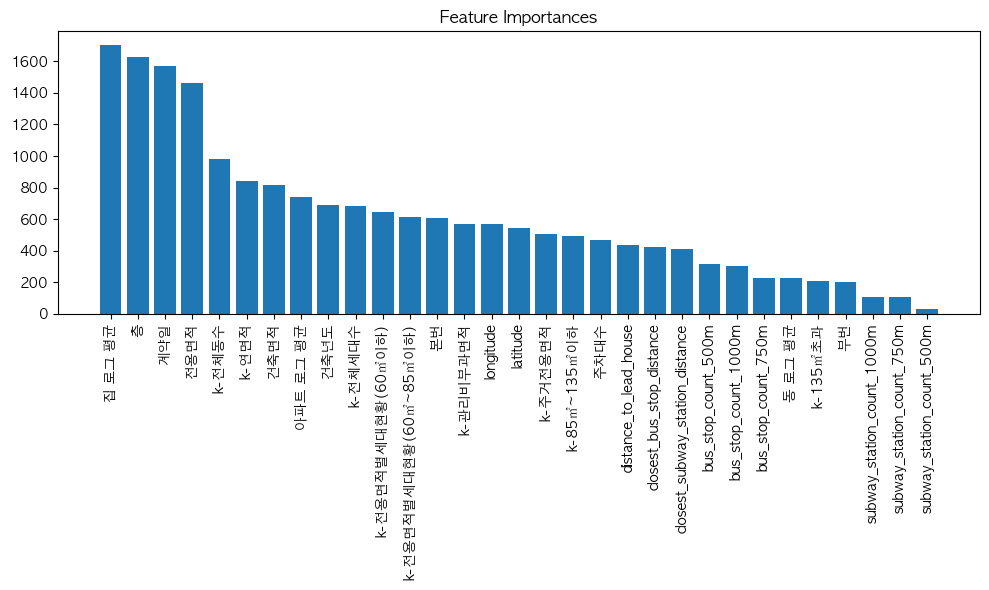

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# 특성 중요도와 특성 이름 가져오기
importances = model.feature_importance()

feature_names = X.columns  # X는 특성 데이터프레임

# 중요도에 따라 특성 정렬
indices = np.argsort(importances)[::-1]

# 시각화
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()